In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
import ForwardDiff
import DiffResults
using AstrodynamicsBase
using Printf
using JSON
using CSV
using DataFrames
using ColorSchemes
using LaTeXStrings

In [2]:
include("../src/SailorMoon.jl")   # relative path to main file of module
param3b = SailorMoon.dynamics_parameters()
paramMulti = SailorMoon.multi_shoot_parameters(param3b)
gr()
fs = 16;


┌ Warning: Replacing docs for `Main.SailorMoon.integrate_rk4 :: Union{Tuple{ODEProblem, Real}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool, Bool}}` in module `Main.SailorMoon`
└ @ Base.Docs docs\Docs.jl:240


In [3]:
# function to retreive the time series data (t, u(t)) from x0 
function x2time_series(
    x::Vector, 
    dir_func, 
    param_multi,
    scale::Bool=false,
    )

    θm_lpo = x[19+12*param_multi.n_arc]  
    u  = []
    t  = []
    th = []

    x_lr, x_mid, x_LPO, tofs, θs = SailorMoon.unpack_x2(x, param_multi.n_arc, false, scale)

    res, sol_param_list, sols_ballistic, tofs = SailorMoon.multishoot_trajectory2(x, dir_func, param_multi, true, false, scale)
        
    # ballistic legs
    for sol_ballistic in sols_ballistic
        u = sol_ballistic.u[:]
        t = sol_ballistic.t[:]
        println("t_bal;", t[1], " ", t[end])
        th = [[0,0,0] for i in collect(1:size(u,1))]

    end
    
    # nonbalistic legs: lr_bck -> lr_fwd -> mid_bck -> mid_fwd -> lpo_bck
    for j = 1:Int(floor(length(sol_param_list)/param_multi.n_arc))
        
        for k = 1:param_multi.n_arc
            
            if mod(j,2) == 1
                # backward propagation
                sol, _, name = sol_param_list[length(sol_param_list) - j*param_multi.n_arc + k]
                t_append = sol.t[:] .+ t[end]
                u_append = sol.u[:]

                # somehow, get a thrust parameter (1x3 double)
                if j == 5      # lr_bck
                    params = x_lr[10 : 9+3*param_multi.n_arc]
                elseif j == 3  # mid_bck
                    params = x_mid[10 : 9+3*param_multi.n_arc]                    
                elseif j == 1  # lpo_bck
                    params = x_LPO[5 : end]
                end 

                # println("test: ", params[13:15])
                thrust_angle = params[3*(param_multi.n_arc-k+1)-2 : 3*(param_multi.n_arc-k+1)]
                
            else
                # forward propagation
                sol, _, name = sol_param_list[length(sol_param_list)-(j-1)*param_multi.n_arc - k + 1]
                u_append = sol.u[end:-1:1, :]
                t_append = sol.t[end:-1:1] .- sol.t[end] .+ t[end]

                # somehow, get a thrust parameter (1x3 double)
                if j == 4      # lr_fwd
                    params = x_lr[10+3*param_multi.n_arc : end]
                elseif j == 2  # mid_fwd
                    params = x_mid[10+3*param_multi.n_arc : end]
                end 
                
                thrust_angle = params[3*k-2 : 3*k]

            end

            th_append = get_thrust(t_append, u_append, thrust_angle, θm_lpo, dir_func)
            u  = vcat(u, u_append)
            t  = vcat(t, t_append)
            th = vcat(th, th_append)

        end
        
    end
    
    u = Base.Array(u)
    u = hcat(u...)[:,:]
    th = hcat(th...)

    return t, u, th
end

# thrust_param: [τ, γ, β]
function get_thrust(tlist, ulist, thrust_param, θm_lpo, dir_func)
    thrusts = []
    for (idx, tnow) in enumerate(tlist)
        θm    = θm_lpo - param3b.oml*tnow
        unow  = ulist[idx]
        thvec = dir_func(param3b.mus, param3b.as, θm, param3b.oml, unow, thrust_param)
        # thrusts = vcat(thrusts, transpose(thvec))
        push!(thrusts, thvec)

    end 

    return thrusts
end

get_thrust (generic function with 1 method)

In [4]:
### PARAMETERS ###################################
# csv file to load the initial solution
filename = "../run/data/opt_0619_EMrotThrust.csv"
# dv_dir function corresponding to the csv file 
dir_func = SailorMoon.dv_EMrotdir_sb1frame

n_arc = 5

##################################################

if dir_func == SailorMoon.dv_no_thrust
    τ_ig = 0.0
else 
    τ_ig = 1.0
end

# load initial guess
df = CSV.read(filename, DataFrame; header=0);


In [5]:
p_ = plot(
    size=(700,500), 
    frame_style=:box, aspect_ratio=:equal, grid=0.4, 
    legend=false, 
    xlabel=L"t", ylabel=L"val",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

In [28]:
row = df[end-1,:]
x = collect(row[4:end])
# x = SailorMoon.oldx2newx(x, n_arc)
t_, u_, th_  = SailorMoon.x2time_series(x, dir_func, paramMulti, true);
u_array = [u_[:,i] for i in collect(1:size(u_,2))]


θm_lpo = x[19+12*paramMulti.n_arc]  
thrust_param_nomi = [1.0, 0.0, 0.0]
th_nominal = get_thrust(t_, u_array, thrust_param_nomi, θm_lpo, dir_func)
th_nominal = hcat(th_nominal...)

3×1316 Matrix{Float64}:
 -0.0461629  -0.044547  -0.041517  …  0.774377  0.77937   0.78048
  0.998934    0.999007   0.999138     0.632725  0.626564  0.625181
  0.0         0.0        0.0          0.0       0.0       0.0

In [29]:
# compute JC from state in EMrot
function compute_JC(state::Vector)
    x, y, z = state[1], state[2], state[3]
    vx, vy, vz = state[4], state[5], state[6]
    r13 = norm([x-param3b.mu2, y, z])  # Earth - SC
    r23 = norm([x-param3b.mu1, y, z])  # Moon - SC
    
    U = 1/2*(x^2+y^2) + param3b.mu1 / r13 + param3b.mu2 / r23 
    JC = 2*U - (vx^2 + vy^2 + vz^2)
    
    return JC 
end

compute_JC (generic function with 1 method)

In [30]:
θlpo = x[19+12*paramMulti.n_arc]

u_emrots = []
JC_vec = []

for (i, tnow) in enumerate(t_)
    θm = θlpo - param3b.oml * tnow
    u_sb1   = u_[1:6,i]
    u_emrot = SailorMoon.transform_SunB1_to_EMrot(u_sb1, θm, param3b.oml, param3b.as)
    u_emrots = push!(u_emrots, transpose(u_emrot))    
    jc = SailorMoon.compute_JC(u_emrot)
    push!(JC_vec, jc)
    
end
u_emrots = Array(reshape(hcat(u_emrots...), 6, size(u_emrots,1)));



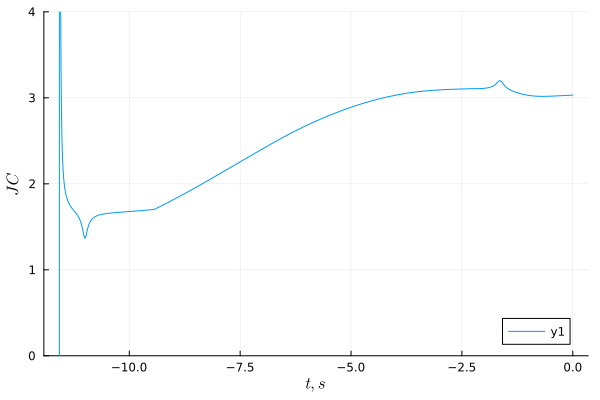

In [31]:
plot(t_, JC_vec, ylim=[0,4], xlabel=L"t,s", ylabel=L"JC")

In [32]:
th_

3×1316 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

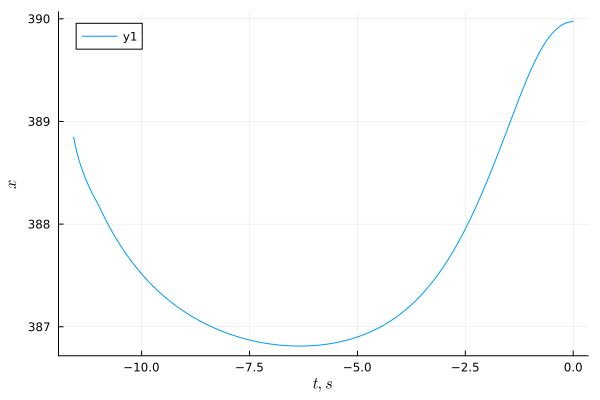

In [33]:
plot(t_, u_[1,:], xlabel=L"t,s", ylabel=L"x")

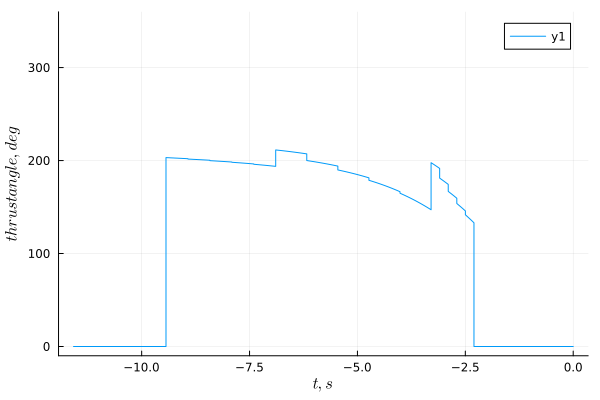

In [34]:
angd = atan.(th_[1,:], th_[2,:])
val = [mod2pi(el)/pi*180 for el in angd]

plot(t_, val, ylim=[-10,360],  xlabel=L"t,s", ylabel=L"thrust angle, deg")
plot(t_,)

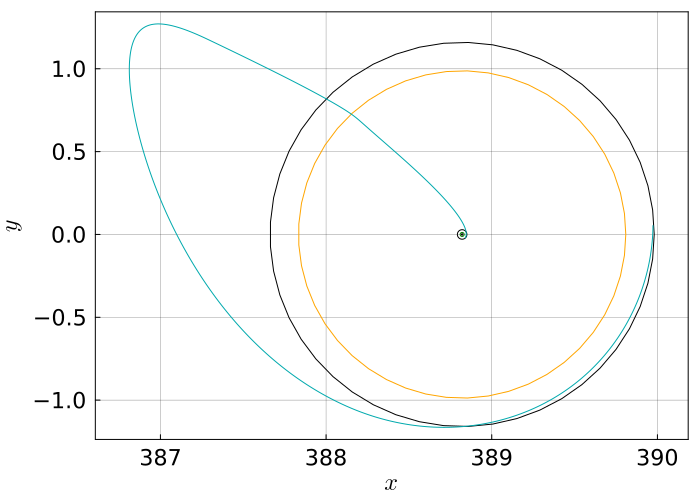

In [13]:
moon     = SailorMoon.plot_circle(1-param3b.mu2, param3b.as , 0.0)
earth    = SailorMoon.plot_circle(param3b.mu2, param3b.as, 0.0)
earth_ub = SailorMoon.plot_circle(param3b.mu2+6375/param3b.lstar, param3b.as, 0.0)
earth_lb = SailorMoon.plot_circle(param3b.mu2-6375/param3b.lstar, param3b.as, 0.0)
moon_soi_outer = SailorMoon.plot_circle(1-param3b.mu2+66000/param3b.lstar, param3b.as, 0.0);


pcart_ = plot(
    size=(700,500), frame_style=:box, aspect_ratio=:equal, grid=0.4, legend=false, 
    xlabel=L"x", 
    ylabel=L"y",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

plot!(pcart_, earth[1,:], earth[2,:], c=:green, lw=1.0, label="earth")
plot!(pcart_, earth_ub[1,:], earth_ub[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart_, earth_lb[1,:], earth_lb[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart_, moon[1,:], moon[2,:], c=:orange, lw=1.0, label="moon")
plot!(pcart_, moon_soi_outer[1,:], moon_soi_outer[2,:], c=:black, lw=1.0, label="moon_soi_outer")
plot!(pcart_,u_[1,:], u_[2,:])




In [ ]:
k = size(u_,2)
m = 20
quiver!(pcart_,u_[1,collect(1:m:k)], u_[2,collect(1:m:k)], quiver=(th_[1,collect(1:m:k)]/10, th_[2,collect(1:m:k)]/10))

In [ ]:
quiver!(pcart_,u_[1,collect(1:m:k)], u_[2,collect(1:m:k)], quiver=(th_[1,:], th_[2,:]))